In [1]:
import wandb

In [2]:
import random 
import math
import copy
import numpy as np
import pandas as pd

import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST

import torch
from torch.nn import MSELoss
from torch.utils.data import random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Adam

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import plotly.express as px
from tqdm import tqdm

In [3]:
class Autoencoder:
    def __init__(self, dataset_path, loss_fn, optim, num_epochs=5, latent_dim=2, lr=0.001, weight_decay=1e-5):
        self.loss_fn = loss_fn
        self.num_epochs = num_epochs

        self.load_dataset(dataset_path)

        self.visualizer()

        torch.manual_seed(0)
        ## Initialize autoencoder
        self.encoder = self.Encoder(encoded_space_dim=latent_dim)
        self.decoder = self.Decoder(encoded_space_dim=latent_dim)
        params_to_optimize = [ {'params': self.encoder.parameters()}, {'params': self.decoder.parameters()} ]
        ## Initialize optimizer
        self.optim = optim(params_to_optimize, lr=lr, weight_decay=weight_decay)
        # Check if the GPU is available
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        print(f'Selected device: {self.device}')
        self.encoder.to(self.device)
        self.decoder.to(self.device)

    #######################
    ## Encoder Sub Class ##
    #######################
    class Encoder(nn.Module):
        def __init__(self, encoded_space_dim):
            super().__init__()
            self.encoder_cnn = nn.Sequential(
                nn.Conv2d(1, 8, 3, stride=2, padding=1),
                nn.ReLU(True),
                nn.Conv2d(8, 16, 3, stride=2, padding=1),
                nn.BatchNorm2d(16),
                nn.ReLU(True),
                nn.Conv2d(16, 32, 3, stride=2, padding=0),
                nn.ReLU(True)
            )
            ## Linear Layers
            self.flatten = nn.Flatten(start_dim=1)
            self.encoder_lin = nn.Sequential(
                nn.Linear(3 * 3 * 32, 128),
                nn.ReLU(True),
                nn.Linear(128, encoded_space_dim)
            )

        def forward(self, x):
            x = self.encoder_cnn(x)
            x = self.flatten(x)
            x = self.encoder_lin(x)
            return x
    

    #######################
    ## Decoder Sub Class ##
    #######################
    class Decoder(nn.Module):
        def __init__(self, encoded_space_dim):
            super().__init__()
            self.decoder_lin = nn.Sequential(
                nn.Linear(encoded_space_dim, 128),
                nn.ReLU(True),
                nn.Linear(128, 3 * 3 * 32),
                nn.ReLU(True)
            )
            ## Linear Layers
            self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))
            self.decoder_conv = nn.Sequential(
                nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
                nn.BatchNorm2d(16),
                nn.ReLU(True),
                nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
                nn.BatchNorm2d(8),
                nn.ReLU(True),
                nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
            )

        def forward(self, x):
            x = self.decoder_lin(x)
            x = self.unflatten(x)
            x = self.decoder_conv(x)
            x = torch.sigmoid(x)
            return x
    
    #####################
    ## Dataset Methods ##
    #####################
    def load_dataset(self, dataset_path):
        ## Initialize datasets
        train_dataset = MNIST(dataset_path, train=True, download=False)
        test_dataset  = MNIST(dataset_path, train=False, download=False)
        ## Define transformers
        train_transform = transforms.Compose( [transforms.ToTensor(),] )
        test_transform = transforms.Compose( [transforms.ToTensor(),] )
        ## Define transformed datasets
        train_dataset.transform = train_transform
        test_dataset.transform = test_transform
        ## Define train test split
        num_train = len(train_dataset)
        num_test = num_train*train_test_split
        ## Split training data
        train_data, val_data = random_split(train_dataset, [int(num_train-num_test), int(num_test)])
        ## Define data loaders
        train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
        valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
        ## Return
        self.train_dataset, self.test_dataset = train_dataset, test_dataset
        self.train_loader, self.valid_loader, self.test_loader = train_loader, valid_loader, test_loader

    def visualizer(self):
        data = self.train_loader.dataset[0]
        tensor = data[0]
        plt.imshow(tensor.numpy()[0], cmap='gray')
        plt.title('Sample Image From Training Dataset')

    def add_noise(self, data):
        new_data = copy.deepcopy(data)
        for tensor_ind, tensor in enumerate(new_data):
            rand_tensor = noise_factor * torch.rand(tensor.shape)
            new_tensor = tensor.add(rand_tensor)
            new_data[tensor_ind] = new_tensor / torch.max(new_tensor)
        return new_data

    #############################
    ## Iterative Model Methods ##
    #############################
    def train_model(self):
        self.encoder.train()
        self.decoder.train()
        train_loss = []
        
        for image_batch, _ in self.train_loader:
            noisy_batch = self.add_noise(image_batch)
            noisy_batch = noisy_batch.to(self.device)    
            
            encoded_batch = self.encoder(noisy_batch)
            decoded_batch = self.decoder(encoded_batch)
            
            conc_out, conc_label = decoded_batch.cpu(), image_batch.cpu()
            
            loss_mse = self.loss_fn(decoded_batch, image_batch)
            loss_cat = self.loss_fn(conc_out, conc_label)
            loss = loss_mse + loss_cat
            
            self.optim.zero_grad()
            loss.backward()
            self.optim.step()
            
            train_loss.append(loss.detach().cpu().numpy())

        return np.mean(train_loss)

    def test_model(self):
        self.encoder.eval()
        self.decoder.eval()

        with torch.no_grad():
            conc_out = []
            conc_label = []

            for image_batch, _ in self.test_loader:
                noisy_batch = self.add_noise(image_batch)
                noisy_batch = noisy_batch.to(self.device)

                encoded_batch = self.encoder(noisy_batch)
                decoded_batch = self.decoder(encoded_batch)

                conc_out.append(decoded_batch.cpu())
                conc_label.append(image_batch.cpu())

            conc_out = torch.cat(conc_out)
            conc_label = torch.cat(conc_label) 
            val_loss = self.loss_fn(conc_out, conc_label)
            
        return val_loss.data

    ### Model Training ###
    def train_model_epochs(self):
        model_loss = {'train_loss':[],'test_loss':[]}
        
        for epoch in range(self.num_epochs):
            train_loss = self.train_model()
            test_loss = self.test_model()
            model_loss['train_loss'].append(train_loss)
            model_loss['test_loss'].append(test_loss)
            print(f'EPOCH {epoch + 1}/{self.num_epochs} \t train loss {train_loss} \t test loss {test_loss}')
            self.plot_sample_batch()

        self.model_loss = model_loss

    ######################
    ## Plotting Methods ##
    ######################
    def plot_model_loss(self):
        plt.figure(figsize=(10,8))
        plt.semilogy(self.model_loss['train_loss'], label='Train')
        plt.semilogy(self.model_loss['test_loss'], label='Test')
        plt.xlabel('Epoch')
        plt.ylabel('Batch Average Loss')
        plt.title('Model Loss Per Epoch')
        plt.legend()
        plt.show()

    def plot_sample_batch(self):
        n = num_display_images
        plt.figure(figsize=(20, 6))
        
        for i in range(n):
            img = self.test_dataset[i][0].unsqueeze(0).to(self.device)
            noisy_img = self.add_noise(img)
            self.encoder.eval()
            self.decoder.eval()
            with torch.no_grad():
                rec_img  = self.decoder(self.encoder(noisy_img))
            
            ax = plt.subplot(3, n, i+1)
            plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)  
            if i == math.floor(n/2):
                ax.set_title('Source Images')

            ax = plt.subplot(3, n, i+1+n)
            plt.imshow(noisy_img.cpu().squeeze().numpy(), cmap='gist_gray')  
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)  
            if i == math.floor(n/2):
                ax.set_title('Input Images (Noisy)')

            ax = plt.subplot(3, n, i+1+ 2*n)
            plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)  
            if i == math.floor(n/2):
                ax.set_title('Reconstructed Images')
        plt.show()

    def plot_latent_images(self, r0=(-10, 10), r1=(-10, 10), width=28, space_definition=20):
        plt.figure(figsize=(20, 8.5))
        img = np.zeros((space_definition*width, space_definition*width))
        for i, y in enumerate(np.linspace(*r1, space_definition)):
            for j, x in enumerate(np.linspace(*r0, space_definition)):
                z = torch.Tensor([[x, y]]).to(self.device)
                x_hat = self.decoder(z).reshape(width, width).to('cpu').detach().numpy()
                img[(space_definition-1-i)*width:(space_definition-1-i+1)*width, j*width:(j+1)*width] = x_hat
        plt.imshow(img, extent=[*r0, *r1], cmap='gist_gray')
        plt.title('Decoded Visualization of Latent Space')

    ##########################
    ## Latent Space Methods ##
    ##########################
    def gen_latent_pop(self, samp_size=0):
        ## samp_size = 0 samples the entire test population
        latent_pop = []
        for samp_ind, sample in enumerate(tqdm(self.test_dataset)):
            if samp_size != 0 and samp_ind > samp_size:
                break
            img = sample[0].unsqueeze(0).to(self.device)
            label = sample[1]
            
            self.encoder.eval()
            with torch.no_grad():
                latent_val  = self.encoder(img)
            
            latent_val = latent_val.flatten().cpu().numpy()
            latent_samp = {f"Enc. Variable {i}": enc for i, enc in enumerate(latent_val)}
            latent_samp['label'] = label
            latent_pop.append(latent_samp)
        latent_pop_df = pd.DataFrame(latent_pop)
        latent_pop_df.head()
        return latent_pop_df

    def plot_latent_topology(self, latent_pop_df):
        ### Euclidean Graph ###
        #######################
        fig = px.scatter(
            latent_pop_df, x='Enc. Variable 0', y='Enc. Variable 1',
            color=latent_pop_df.label.astype(str), opacity=0.7,
        )
        fig.update_layout(title='2D Representation of Datapoints in Latent Space')
        fig.show()
        ### TSNE Graph ###
        ##################
        tsne = TSNE(n_components=2)
        tsne_results = tsne.fit_transform(latent_pop_df.drop(['label'], axis=1))
        fig = px.scatter(
            tsne_results, x=0, y=1,
            color=latent_pop_df.label.astype(str), labels={'0':'tsne-2d-0', '1':'tsne-2d-1'}
        )
        fig.update_layout(title='TSNE Representation of Datapoints in Latent Space')
        fig.show()

In [4]:
# Autoencoder Parameters
latent_dim = 2

# Autoencoder Learning Parameters
lr = 0.001
weight_decay = 1e-5
train_test_split = 0.2

loss_fn = MSELoss()

# (training) number of epochs spent training
num_epochs = 20

# (training + testing) batch size
batch_size = 256

# (training + testing) image noise level
noise_factor = 2

num_display_images = 9

latent_samp_size = 0

dataset_path = 'data'

/usr/local/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Selected device: cpu
EPOCH 1/20 	 train loss 1.0 	 test loss 0.20333358645439148


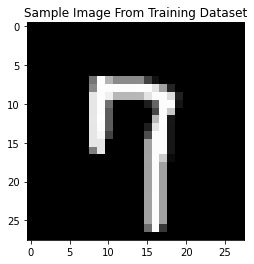

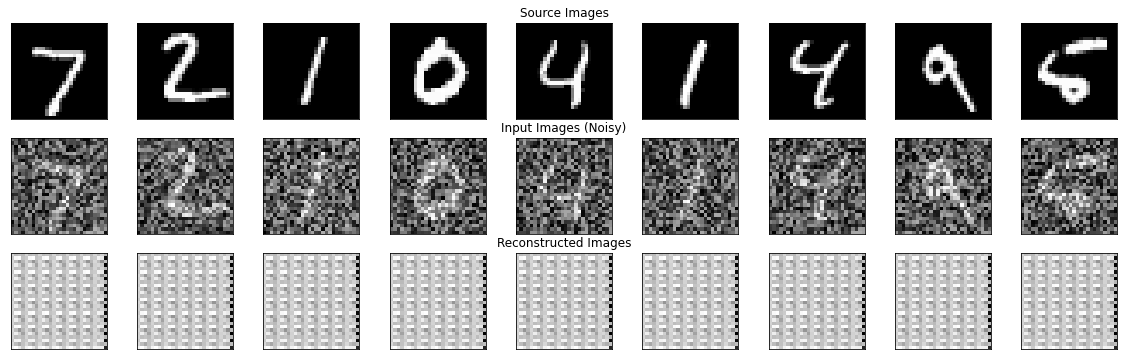

EPOCH 2/20 	 train loss 1.0 	 test loss 0.22049936652183533


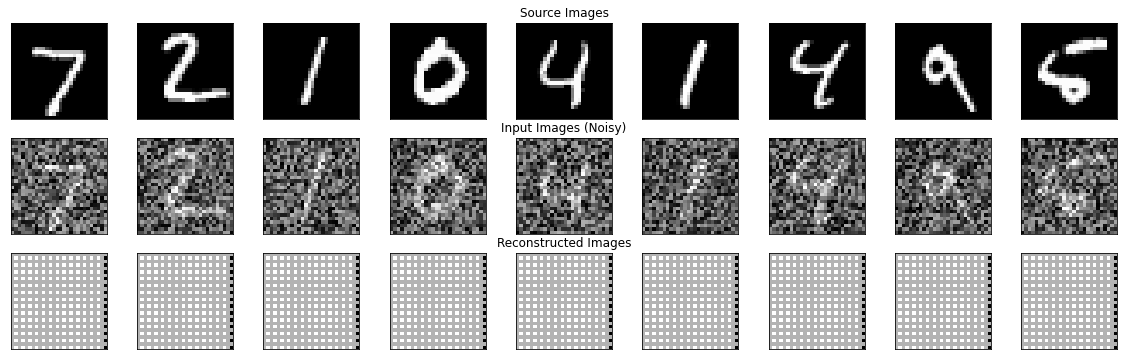

EPOCH 3/20 	 train loss 1.0 	 test loss 0.2283172905445099


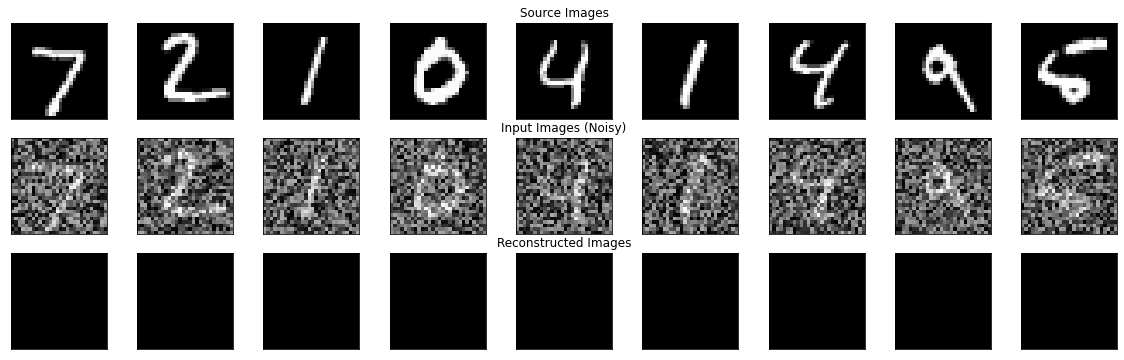

EPOCH 4/20 	 train loss 1.0 	 test loss 0.23080852627754211


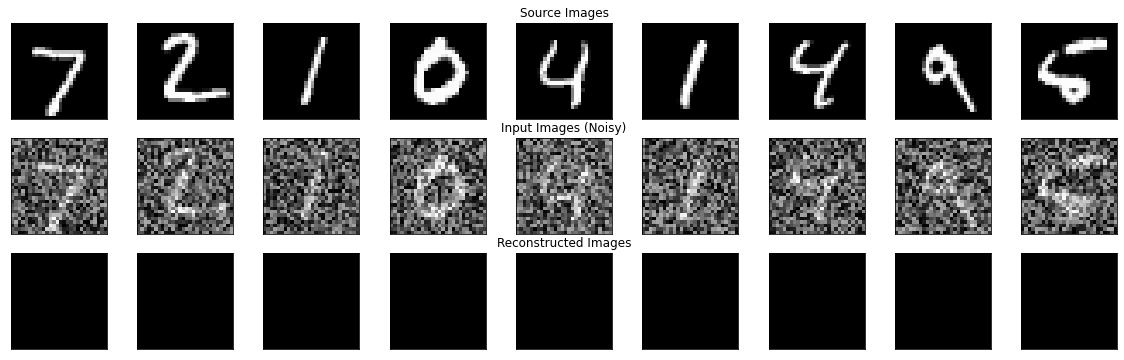

In [5]:
ae = Autoencoder(dataset_path, loss_fn, Adam, num_epochs=num_epochs, latent_dim=latent_dim)

### Model Training ###
ae.train_model_epochs()

ae.plot_model_loss()

### Model Testing ###
ae.test_model().item()


ae.plot_latent_images(r0=(-1, 1), r1=(-1, 1))
latent_pop_df = ae.gen_latent_pop(samp_size=latent_samp_size)
ae.plot_latent_topology(latent_pop_df)